In [2]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [3]:
train_data = datasets.FashionMNIST(root='Data', train=True, transform=torchvision.transforms.ToTensor(), download=True, target_transform=None)
test_data = datasets.FashionMNIST(root='Data', train=False, transform=torchvision.transforms.ToTensor(), download=True, target_transform=None)

100%|██████████| 26.4M/26.4M [00:48<00:00, 542kB/s] 
100%|██████████| 29.5k/29.5k [00:00<00:00, 817kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.35MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 5.11MB/s]


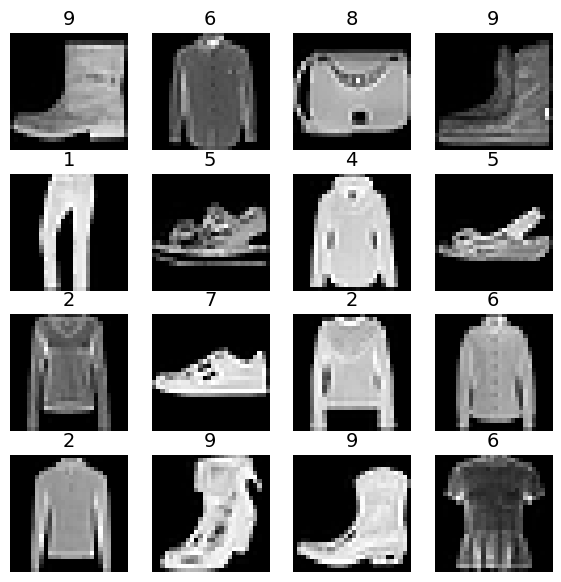

In [6]:
torch.manual_seed(42)
fig = plt.figure(figsize=(7,7))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap='gray')
  plt.title(label, fontsize=14)
  plt.axis(False)

In [7]:
batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [9]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape , train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [10]:
flatten_model = nn.Flatten()
x = train_features_batch[0]
output = flatten_model(x)

print(f"Shape before the flatten layer: {x.shape}")
print(f"Shape after the flatten layer: {output.shape}")

Shape before the flatten layer: torch.Size([1, 28, 28])
Shape after the flatten layer: torch.Size([1, 784])


In [ ]:
def